# Markov chain Monte Carlo

The main technical challenge in using Bayesian models resides in calculating the model's joint posterior distribution. 

Recall that we are interested in combining the information from our data, via the **likelihood** $Pr(y|\theta)$, and prior information, via the **prior distribution** $Pr(\theta)$, to produce a joint posterior distribution for the model of interest:

\begin{align}
Pr(\theta | y) \propto Pr(y|\theta) Pr(\theta)
\end{align}


However, to guarantee that the posterior is itself a proper probability density (and not just proportional to one), it has to be normalized by dividing by the **marginal likelihood**:
\begin{align}
Pr(\theta | y) = \frac{Pr(y|\theta) Pr(\theta)}{Pr(y)}
\end{align}


The marginal likelihood is the numerator, integrated over the parameters $\theta$:
\begin{align}
Pr(\theta | y) = \frac{Pr(y|\theta) Pr(\theta)}{\int_{\theta} Pr(y|\theta) Pr(\theta) d\theta}
\end{align}
which, except for very simple (one- or two-parameter) models cannot be calculated analytically.

* The two alternative strategies to obtaining posteriors for moderate to large models involve either analytic **approximations** or stochastic **sampling**. 
* Approximations (Variational Inference) are usually valid conditional on assumptions regarding the true posterior distribution ( however, the assumptions can be difficult to validate).
* Direct sampling strategies rely on our ability to sample from the posterior distribution, and this is frequently not possible. 
* The sampling approaches aim to obtain *independent* samples from the posterior distribution. 
* It turns out, however, that it is possible to generate samples from the posterior distribution using a *dependent* sampling algorithm, and despite the dependence of the samples, one may extract valid inference from them. 
* A class of algorithms called **Markov chain Monte Carlo** yields a Markovian sample (explained below) which, provided that certain conditions are satisfied, is guaranteed to be indistinguishable from a sample drawn from the true posterior itself.

## Markov Chains

* A Markov chain is a special type of **stochastic process**. The standard definition of a stochastic process is an ordered collection of random variables:
\begin{align}
\{X_t: t \in T\}
\end{align}



where $t$ is frequently (but not necessarily) a time index. 
* If we think of $X_t$ as a state $X$ at time $t$, and invoke the following dependence condition on each state:
\begin{align}
Pr(X_{t+1}=x_{t+1} | X_t=x_t, X_{t-1}=x_{t-1},\ldots,X_0=x_0) = Pr(X_{t+1}=x_{t+1} | X_t=x_t)
\end{align}


then the stochastic process is known as a **Markov chain**. 
* This specifies that the future depends on the current state, but **not past states**. Thus, the Markov chain wanders about the state space, remembering only where it has just been in the last time step. 
* The collection of transition probabilities is sometimes called a **transition matrix** when dealing with discrete states, or more generally, a **kernel**.

* In the context of Markov chain Monte Carlo, it is useful to think of the Markovian property as **mild non-independence**. 
* MCMC allows us to indirectly generate independent samples from a particular posterior distribution.


## Why MCMC Works: Reversible Markov Chains

* Markov chain Monte Carlo simulates a Markov chain for which some function of interest
    (*e.g.* the joint distribution of the parameters of some model) is the unique, invariant limiting distribution. An invariant distribution with respect to some Markov chain with transition kernel $Pr(y \mid x)$ implies that:
\begin{align}
\int_x Pr(y \mid x) \pi(x) dx = \pi(y).
\end{align}



* Invariance is guaranteed for any **reversible** Markov chain. Consider a Markov chain in reverse sequence:
$\{\theta^{(n)},\theta^{(n-1)},...,\theta^{(0)}\}$. This sequence is reversibly Markovian if
\begin{align}
Pr(\theta^{(k)}=y \mid \theta^{(k+1)}=x,\theta^{(k+2)}=x_1,\ldots ) = Pr(\theta^{(k)}=y \mid \theta^{(k+1)}=x)
\end{align}



* Forward and reverse transition probabilities may be related through Bayes theorem:
\begin{align}
Pr(\theta^{(k)}=y \mid \theta^{(k+1)}=x) = \frac{Pr(\theta^{(k+1)}=x \mid \theta^{(k)}=y) \pi^{(k)}(y)}{\pi^{(k+1)}(x)}
\end{align}



* A key point to note here is that $\pi^{(k)}(y)\,\&\, \pi^{(k+1)}(x)$ are not necessarily the same distribution for $x\, \& \,y$ in general, **but** $\pi$ becomes homogeneous (i.e the same for the *entire* Markov chain ) if:

    -   $n \rightarrow \infty$

    -   $\pi^{(i)}=\pi$ for some $i < k$

* If this chain is homogeneous it is called reversible, because it satisfies the **detailed balance equation**:
\begin{align}
\pi(x)Pr(y \mid x) = \pi(y) Pr(x \mid y)
\end{align}


* Reversibility of a Markov chain implies that $\pi$ is the unique, invariant, stationary distribution of that chain. 
* Hence, if $\pi$ is of interest, we need only find the reversible Markov chain for which $\pi$ is the limiting distribution.
**This is what MCMC does!**


## The Metropolis-Hastings Algorithm

One of the simplest and most flexible algorithms for generating reversible Markov chains is the Metropolis-Hastings algorithm. Since we cannot sample directly from the (unknown) posterior distribution, this algorithm employs an **auxilliary distribution** that is easy to sample from. These samples generate candidate state transitions, which are accepted or rejected probabilistically.

![](Metropolis.png)

Let us first consider a simple Metropolis-Hastings algorithm for a single parameter, $\theta$. We will use a well-known statistical distribution to produce candidate variables $q_t(\theta^{\prime} | \theta)$. Each generated value, $\theta^{\prime}$, is a *possible* next value for
$\theta$ at step $t+1$. 

Whether or not $\theta^{\prime}$ is accepted depends on the relative probability of the new value versus the current value, weighted by the probabilities of the two values under the proposal distribution: 

$$a(\theta^{\prime},\theta) = \frac{q_t(\theta^{\prime} | \theta) \pi(\theta^{\prime})}{q_t(\theta | \theta^{\prime}) \pi(\theta)}$$

This is the **acceptance ratio**, and is used as a threshold value for a uniform random draw that determines acceptance:

$$
\theta^{(t+1)} = 
\begin{cases}
\theta^{\prime}  & \text{with prob. } p = \min(a(\theta^{\prime},\theta^{(t)}),1)\cr
\theta^{(t)}  & \text{with prob } 1 - p
\end{cases}
$$

This transition kernel implies that movement is not guaranteed at every step. It only occurs if the suggested transition is likely based on the acceptance ratio.

A single iteration of the Metropolis-Hastings algorithm proceeds as follows:

1.  Sample $\theta^{\prime}$ from $q(\theta^{\prime} | \theta^{(t)})$.

2.  Generate a Uniform[0,1] random variate $u$.

3.  If $a(\theta^{\prime},\theta) > u$ then
    $\theta^{(t+1)} = \theta^{\prime}$, otherwise
    $\theta^{(t+1)} = \theta^{(t)}$.
    

### Random-walk Metropolis-Hastings

We still have not talked about how to choose the proposal $q$. In principle, it can be just about anything, but some choices are wiser than others. A practical implementation of the Metropolis-Hastings algorithm makes use of a **random-walk** proposal.

A random walk is a Markov chain that evolves according to:

$$\begin{aligned}
\theta^{(t+1)} &= \theta^{(t)} + \epsilon_t \\
\epsilon_t &\sim f(\phi)
\end{aligned}$$

As applied to the MCMC sampling, the random walk is used as a proposal distribution, whereby dependent proposals are generated according to:

$$q(\theta^{\prime} | \theta^{(t)}) = f(\theta^{\prime} - \theta^{(t)}) = \theta^{(t)} + \epsilon_t$$

Generally, the density generating $\epsilon_t$ is **symmetric** about zero,
resulting in a symmetric chain. Chain symmetry implies that
$q(\theta^{\prime} | \theta^{(t)}) = q(\theta^{(t)} | \theta^{\prime})$,
which reduces the Metropolis-Hastings acceptance ratio to:

$$a(\theta^{\prime},\theta) = \frac{\pi(\theta^{\prime})}{\pi(\theta)}$$

The choice of the random walk distribution for $\epsilon_t$ is frequently a normal or Student’s $t$ density, but it may be any distribution that generates an irreducible proposal chain.

An important consideration is the specification of the **scale parameter** for the random walk error distribution. Large values produce random walk steps that are highly exploratory, but tend to produce proposal values in the tails of the target distribution, potentially resulting in very small acceptance rates. Conversely, small values tend to be accepted more frequently, since they tend to produce proposals close to the current parameter value, but may result in chains that mix very slowly.

Some simulation studies suggest optimal acceptance rates in the range of **20-50%**. It is often worthwhile to optimize the proposal variance by iteratively adjusting its value, according to observed acceptance rates early in the MCMC simulation .

## Example: Linear model estimation

* This very simple dataset is a selection of real estate prices, with the associated age of each house. We wish to estimate a simple linear relationship between the two variables, using the Metropolis-Hastings algorithm.

$$\mu_i = \beta_0 + \beta_1 a_i$$

$$p_i \sim \mathcal{N}(\mu_i, \tau)$$

* The target $p_i$ in any linear regression problem is considered to be the model prediction + a random noise whose variance (or precision) is denoted as $\tau$ here

$$\tau \sim \Gamma(0.001, 0.001) $$



* The unnormalized log-posterior PDF can be expressed as
$$logp(\beta_0 , \beta_1,\tau) = log\mathcal{N}(\mathbf{P}|\mathbf{y,X},\beta_0 , \beta_1, \tau) + logp(\beta_0)+logp(\beta_1)+logp(\tau)$$


In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

age = np.array([13, 14, 14,12, 9, 15, 10, 14, 9, 14, 13, 12, 9, 10, 15, 11, 
                15, 11, 7, 13, 13, 10, 9, 6, 11, 15, 13, 10, 9, 9, 15, 14, 
                14, 10, 14, 11, 13, 14, 10])
price = np.array([2950, 2300, 3900, 2800, 5000, 2999, 3950, 2995, 4500, 2800, 
                  1990, 3500, 5100, 3900, 2900, 4950, 2000, 3400, 8999, 4000, 
                  2950, 3250, 3950, 4600, 4500, 1600, 3900, 4200, 6500, 3500, 
                  2999, 2600, 3250, 2500, 2400, 3990, 4600, 450,4700])/1000.

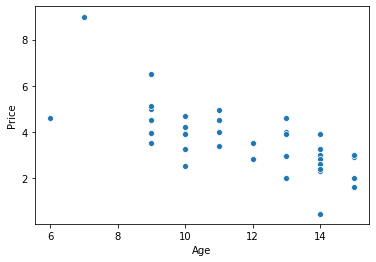

In [2]:
sns.scatterplot(age, price)
plt.xlabel('Age')
plt.ylabel('Price');

This function calculates the joint log-posterior, conditional on values for each paramter:

In [3]:
from scipy.stats import gamma, norm
dgamma = gamma.logpdf
dnorm = norm.logpdf

def calc_posterior(a, b, t, y=price, x=age):
    # Calculate joint posterior, given values for a, b and t

    # Priors on a,b
    logp = dnorm(a, 0, 10000) + dnorm(b, 0, 10000)
    # Prior on t
    logp += dgamma(t, 0.001, 0.001)
    # Calculate mu
    mu = a + b*x
    # Data likelihood
    logp += sum(dnorm(y, mu, t**-0.5))
    
    return logp

In [4]:
rnorm = np.random.normal
runif = np.random.rand
np.random.seed(42)

def metropolis(n_iterations, initial_values, prop_var=1):

    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])
    
    # Initialize acceptance counts
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if ((i+1)%1000==0 or i==0): print('Iteration %d' %( i+1))
    
        # Grab current parameter values
        current_params = trace[i]
    
        for j in range(n_params):
    
            # Get current value for parameter j
            p = trace[i].copy()
    
            # Propose new value
            if j==2:
                # Ensure tau is positive
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                
    return trace, accepted

Let's run the MH algorithm with a very small proposal variance:

In [10]:
n_iter = 5000
trace_lowvar, acc = metropolis(n_iter, (1,0,1), 0.001)

Iteration 1
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000


We can see that the acceptance rate is way too high:

In [11]:
np.array(acc, float)/n_iter

array([0.9702, 0.9542, 0.9534])

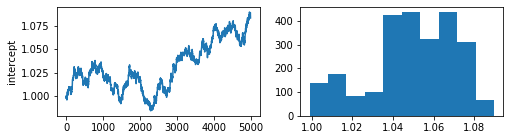

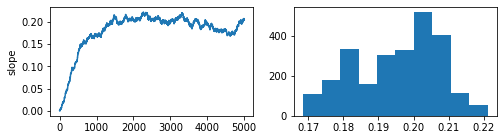

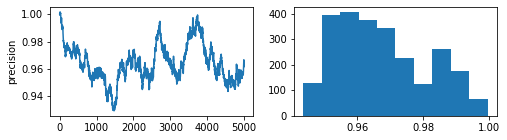

In [12]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(n_iter/2):])

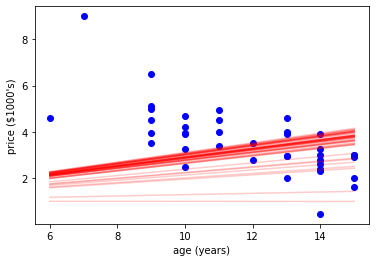

In [24]:
plt.plot(age, price, 'bo')
plt.xlabel('age (years)'); plt.ylabel('price ($1000\'s)')
xvals = np.linspace(age.min(), age.max())
for i in range(50):
    b0,b1,tau = trace_lowvar[np.random.randint(0, 5000)]
    plt.plot(xvals, b0 + b1*xvals, 'r-', alpha=0.2)

Now, with a very large proposal variance:

In [14]:
trace_hivar, acc = metropolis(n_iter, (1,0,1), 20)

Iteration 1
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000


In [15]:
np.array(acc, float)/n_iter

array([0.0174, 0.0008, 0.0122])

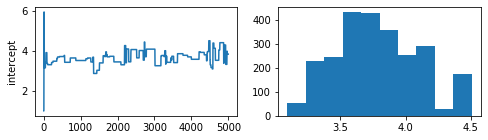

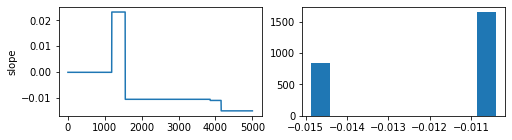

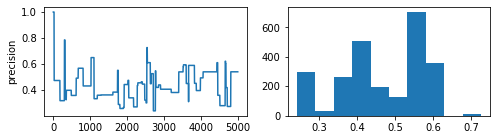

In [16]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace_hivar.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(n_iter/2):])

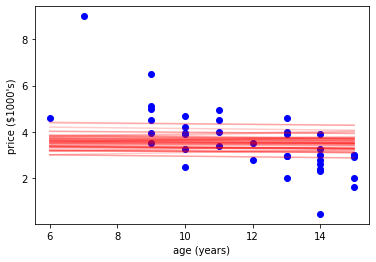

In [25]:
plt.plot(age, price, 'bo')
plt.xlabel('age (years)'); plt.ylabel('price ($1000\'s)')
xvals = np.linspace(age.min(), age.max())
for i in range(50):
    b0,b1,tau = trace_hivar[np.random.randint(0, 5000)]
    plt.plot(xvals, b0 + b1*xvals, 'r-', alpha=0.2)

In order to avoid having to set the proposal variance by trial-and-error, we can add some tuning logic to the algorithm. 

## Auto-tuning Metropolis-Hastings

We can modify the Metropolis-Hastings algorithm above by adding logic to automatically change the proposal scale depending on the acceptance rate of the chain. 

In [18]:
def metropolis_tuned(n_iterations, initial_values, prop_var=1, 
                     tune_for=None, tune_interval=100):
     
    n_params = len(initial_values)
             
    # Initial proposal standard deviations
    prop_sd = [prop_var] * n_params
     
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
     
    # Set initial values
    trace[0] = initial_values
    # Initialize acceptance counts
    accepted = [0]*n_params
     
    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])
     
    if tune_for is None:
        tune_for = n_iterations/2
     
    for i in range(n_iterations):
     
        if ((i+1)%1000==0 or i==0): print('Iteration %d' %( i+1))
     
        # Grab current parameter values
        current_params = trace[i]
     
        for j in range(n_params):
     
            # Get current value for parameter j
            p = trace[i].copy()
     
            # Propose new value
            if j==2:
                # Ensure tau is positive
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
             
            # Insert new value 
            p[j] = theta
     
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)
     
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
     
            # Sample a uniform random variate
            u = runif()
     
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                 
            # Tune every 100 iterations
            if (not (i+1) % tune_interval) and (i < tune_for):
         
                # Calculate aceptance rate
                acceptance_rate = (1.*accepted[j])/tune_interval
                if acceptance_rate<0.2:
                    prop_sd[j] *= 0.9
                elif acceptance_rate>0.4:
                    prop_sd[j] *= 1.1
                accepted[j] = 0
                 
    return trace[tune_for:], accepted

In [19]:
trace_tuned, acc = metropolis_tuned(10000, (10,0,1), tune_for=5000,tune_interval=10)

Iteration 1
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000


In [20]:
np.array(acc, float)/5000

array([0.3516, 0.2856, 0.2774])

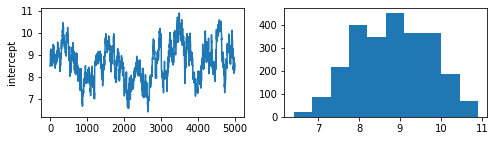

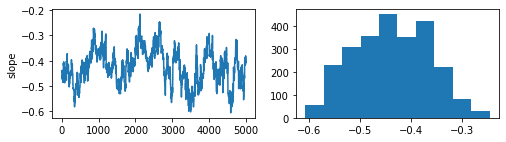

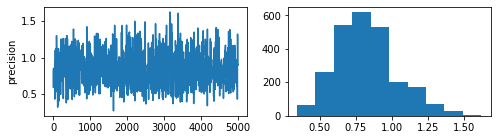

In [21]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace_tuned.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(len(samples)/2):])

In [22]:
print("Mean value of slope:%f"%(np.average(trace_tuned[:,1])))
print("Mean value of Intercept:%f"%(np.average(trace_tuned[:,0])))
print("Mean value of Noise Precision:%f"%(np.average(trace_tuned[:,2])))

print("STDEV value of slope:%f"%(np.std(trace_tuned[:,1])))
print("STDEV value of Intercept:%f"%(np.std(trace_tuned[:,0])))
print("STDEV value of Noise Precision:%f"%(np.std(trace_tuned[:,2])))


Mean value of slope:-0.426483
Mean value of Intercept:8.660842
Mean value of Noise Precision:0.825876
STDEV value of slope:0.069351
STDEV value of Intercept:0.842676
STDEV value of Noise Precision:0.211041


A useful way to informally examine the fit of the model is to examine functions of the posterior distribution. For example, here are 50 random regression lines drawn from the posterior:

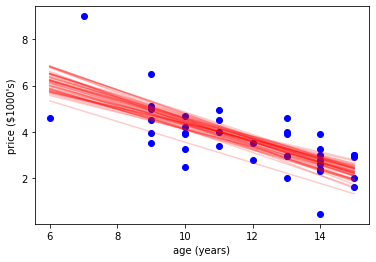

In [23]:
plt.plot(age, price, 'bo')
plt.xlabel('age (years)'); plt.ylabel('price ($1000\'s)')
xvals = np.linspace(age.min(), age.max())
for i in range(50):
    b0,b1,tau = trace_tuned[np.random.randint(0, 1000)]
    plt.plot(xvals, b0 + b1*xvals, 'r-', alpha=0.2)

In [27]:
from sklearn.linear_model import BayesianRidge
blr=BayesianRidge(copy_X=True,fit_intercept=True)


In [28]:
blr.fit(age.reshape((-1,1)),price)


print("Mean value of Slope:",blr.coef_)
print("Mean value of Intercept:",blr.intercept_)
print("Mean value of Noise precision: %f"%(blr.alpha_))

print("STDEV value of slope:",blr.sigma_)
print("STDEV value of Intercept:",None)
print("STDEV value of Noise precision:",None)

Mean value of Slope: [-0.39762751]
Mean value of Intercept: 8.314888538346608
Mean value of Noise precision: 0.939741
STDEV value of slope: [[0.00460862]]
STDEV value of Intercept: None
STDEV value of Noise precision: None


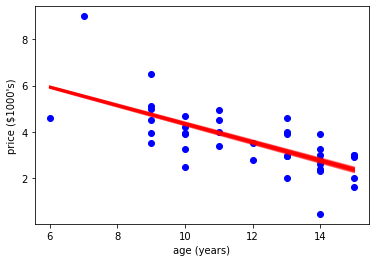

In [29]:
from scipy.stats import norm
plt.plot(age, price, 'bo')
plt.xlabel('age (years)'); plt.ylabel('price ($1000\'s)')
xvals = np.linspace(age.min(), age.max())
for i in range(50):
    b1 = norm.rvs(loc=blr.coef_[0],scale=blr.sigma_[0,0])
    b0,tau=blr.intercept_,blr.alpha_
    plt.plot(xvals, b0 + b1*xvals, 'r-', alpha=0.2)

# Bayesian Analysis Using PyMC3

We will now look at PyMC3, a comprehensive python package to perform sampling, inference and model assessment.



In [32]:
from pymc3 import Model, Normal, Uniform, Gamma
import matplotlib.pyplot as plt
import numpy as np
from pymc3 import  *
import pandas as pd
from pandas.plotting import scatter_matrix
data={'age':age,'price':price}
data=pd.DataFrame(data=data)

with Model() as model:
    priors = {'Intercept': Normal.dist(mu=price.mean(), sigma=price.std()),
              'age': Normal.dist(mu=0, sigma=1000),
              'tau': Gamma.dist(0.001,0.001)
              }
    
    GLM.from_formula(
        'price ~ age', data, priors=priors)
    step=Metropolis()
    trace = sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, age, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████████| 42000/42000 [01:26<00:00, 485.02draws/s]
The acceptance probability does not match the target. It is 0.8814109958333156, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8957146938656685, but should be close to 0.8. Try to increase the number of tuning steps.


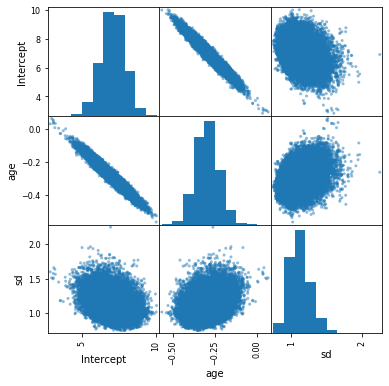

In [33]:
scatter_matrix(trace_to_dataframe(trace), figsize=(6,6));

In [34]:
trace_df = trace_to_dataframe(trace)
print(trace_df.describe().drop('count').T)


               mean       std       min       25%       50%       75%  \
Intercept  7.069958  0.808896  2.830753  6.539462  7.091756  7.620708   
age       -0.296679  0.067513 -0.566285 -0.342652 -0.298188 -0.252220   
sd         1.119237  0.145292  0.745599  1.015958  1.104520  1.205804   

                 max  
Intercept  10.029094  
age         0.066202  
sd          2.246737  


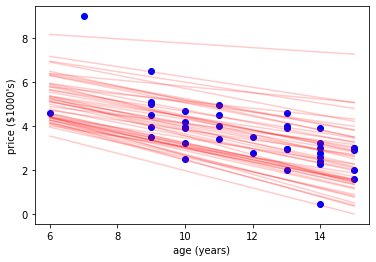

In [38]:
plt.plot(age, price, 'bo')
plt.xlabel('age (years)'); plt.ylabel('price ($1000\'s)')
xvals = np.linspace(age.min(), age.max())
for i in range(50):
    b0,b1,tau = trace_df.Intercept[np.random.randint(5000, 10000)],trace_df.age[np.random.randint(5000,10000)],\
    trace_df.sd[np.random.randint(5000, 10000)]
    plt.plot(xvals, b0 + b1*xvals, 'r-', alpha=0.2)

#### Alternatives
* MATLAB: **mhsample** (Single-Component Adaptation),**hmcsample** (same as NUTS) - refer to mathworks webpage on these functions; it is self-explanatory
* R $\Rightarrow$ **adaptMCMC**: Adaptive Metropolis Scheme with Multi-Component Adaptation 
* R also has other functions/packages that are needed to estimate convergence diagnostics of the Markov Chain. But that can be done with traces generated from MATLAB/Python too.